#q<sup>2</sup> Tutorial - 1. Introduction

Welcome to the q<sup>2</sup> Python package!

*Before we begin this tutorial, make sure to have the 2014 version of <a href="http://www.as.utexas.edu/~chris/moog.html">MOOGSILENT</a> installed. It is assumed that you are somewhat familiar with MOOG.*

*If you are not familiar with Python, know that this package has a number of dependencies such as numpy, scipy, matplotlib, and bokeh. Also, I recommend following this Tutorial on an IPython notebook. The safest way of making sure q<sup>2</sup> will work is to check the requirements file for your system. If you use Anaconda, q<sup>2</sup> should just work. Finally, you should have the directory in which q<sup>2</sup> is located in your PYTHONPATH environment variable.*

*Ready? Go!*

First, let's create a directory Demo, move other there, and import the q<sup>2</sup> package.

The "%matplotlib inline" command allows the images created by q<sup>2</sup> to be shown on the IPython notebook.

In [1]:
import os
if not os.path.exists('Demo'):
    os.mkdir('Demo')
os.chdir('Demo')

import q2

%matplotlib inline

For any given q<sup>2</sup> project, two csv (comma-separated-values) files are required: one with star data such as Teff, logg, etc., and another one with spectral line data, i.e., a line list with atomic data and measured equivalent widths. Let's take a look at the two files used in this example ("standard_stars.csv" and "standards_lines.csv") to have an idea of the format (you should be able to open these files with MS Excel or LibreOffice). Column order is not important, but a few columns are required: id, teff, logg, feh, and vt in the "stars" file, and wavelength, species, ep, and gf in the "lines" file. The EW values of the stars should be given in the "lines" file with a heading corresponding to the id of the star (this is not checked by q<sup>2</sup> to keep it flexible, e.g., to allow you to have additional columns such as comments, source of measurement, etc.).

In this step, the data from the csv files are loaded into an object called data. Nothing will happen to our csv files from now on; in fact, q<sup>2</sup> will never modify them.

In [2]:
data = q2.Data('../standards_stars.csv', '../standards_lines.csv')

We can inspect our data by calling the object attributes "star_data" and "lines" (data.star_data and data.lines are dictionaries of numpy arrays). For example, let's check the stars' ids, Teffs, and the first five EWs of the Sun (compare this output with the data in the csv files to understand what you are doing here):

In [3]:
print data.star_data['id']
print data.star_data['teff']
print data.lines['Sun'][:5]

['Sun' 'Arcturus']
[5777 4286]
[ 29.   62.5  32.6  32.5  80. ]


To begin using q<sup>2</sup>'s tools we need to create Star objects (note that we create the star objects with the star's names exacly as listed in the csv files, or the data object; if you create the star object with a star name that is not in the data object, e.g., "Sol" or "arcturus", q<sup>2</sup> will not be able to figure out what to do with that star):

In [4]:
sun = q2.Star('Sun')
arcturus = q2.Star('Arcturus')

To asign the correct attributes to these stars, as given in our csv files, we use the "get_data_from" method. Our csv files are no longer being used to get this information; the data object is instead employed for that. Let's get the input data for our two stars and print their Teff and logg values (nicely):

In [5]:
sun.get_data_from(data)
arcturus.get_data_from(data)

print "Sun     : Teff = {0:4.0f} K, logg = {1:4.2f}".\
      format(sun.teff, sun.logg)
print "Arcturus: Teff = {0:4.0f} K, logg = {1:4.2f}".\
      format(arcturus.teff, arcturus.logg)

Sun     : Teff = 5777 K, logg = 4.44
Arcturus: Teff = 4286 K, logg = 1.66


Since we also uploaded a master line list (the "lines" csv file), the star objects now also have their own linelist data. These data were also asigned by the "get_data_from" method.

In [6]:
print "Wavelength column (first five):"
print sun.linelist['wavelength'][:5]
print "Equivalent width column (first five):"
print sun.linelist['ew'][:5]

Wavelength column (first five):
[ 5295.3101  5379.5698  5386.3301  5441.3398  5638.2598]
Equivalent width column (first five):
[ 29.   62.5  32.6  32.5  80. ]


Our stars have all fundamental atmospheric parameters defined (they can be input guess values at this point). Therefore, we can use the "get_model_atmosphere method" to look for models or interpolate them from the available grids. Here we will use MARCS models, hence the 'marcs' argument that is passed to this method. For Kurucz models we can use 'odfnew' (the default), 'aodfnew', 'over', or 'nover'.

In [7]:
sun.get_model_atmosphere('marcs')
arcturus.get_model_atmosphere('marcs')

What we just did is to add an attribute model_atmosphere to our star objects sun and arcturus. This attribute is a dictionary of numpy arrays with the model atmosphere information. At any point, we can check what grid the model attached to a given Star object was taken or interpolated from by looking at the model_atmosphere_grid attribute. The code below makes the classic RHOX vs T graph:

Interpolated solar model atmosphere. Grid: marcs


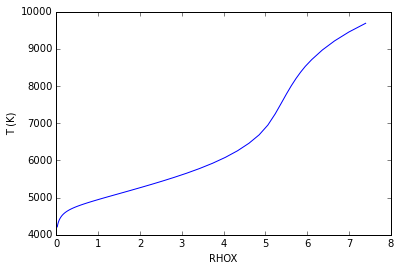

In [8]:
import matplotlib.pylab as plt
plt.plot(sun.model_atmosphere['RHOX'], sun.model_atmosphere['T'])
plt.xlabel("RHOX")
plt.ylabel("T (K)")
print "Interpolated solar model atmosphere. Grid: "+sun.model_atmosphere_grid

Note that the "model_atmosphere" attribute/dictionary has all the necessary physical information to run a MOOG abfind calculation (and our star objects have the linelist data as well). The q2.moog module can help us create input files for a typical MOOG abfind run:

In [9]:
md = q2.moog.Driver()
md.create_file() #Creates a simple MOOGSILENT abfind driver
q2.moog.create_model_in(sun) #creates the model atmosphere file
q2.moog.create_lines_in(sun) #returns True if successful (for internal checks)

True

Let's look for the files we just created in the Demo folder and inspect them (you can open another terminal, cd into this Demo directory and use your favorite text viewer/editor or you can also browse the Demo folder from the IPython notebook main page). They should have the familiar MOOG formats. At this point, you could go to your terminal and try to run MOOGSILENT (or MOOG and then enter batch.par as the driver) on the Demo folder. Of course, it is not terribly helpful if we are still going to have to call MOOG manually from the terminal. Instead, we can use q<sup>2</sup>'s "moog.abfind" function to calculate abundances running MOOG under the hood (let's keep our fingers crossed; this is when q<sup>2</sup> actually talks to MOOG!). In this example, we are computing line-by-line "FeII abundances" for the Sun:

In [10]:
q2.moog.abfind(sun, 26.1, 'fe2')
print sun.fe2.keys()
print sun.fe2['ww']
print sun.fe2['ab']

['ab', 'difab', 'rew', 'ww', 'ew', 'ep']
[ 4576.333  4620.513  5234.624  5264.804  5414.072  5425.257  6369.462
  6432.676  6516.077]
[ 7.353  7.282  7.318  7.45   7.432  7.412  7.402  7.424  7.456]


The "moog.abfind" function ran MOOGSILENT for us, creating the MOOG input files and deleting them when done. The sun object in this example now has an fe2 attribute, which is a dictionary containing the MOOG outputs: ww=wavelength, ab=abundance, etc.

A common exercise in stellar spectroscopy is to derive iron abundances from FeI and FeII lines separately, in addition to calculating some statistics like abundance versus EP or REW slopes. This can be done with the "specpars" module:

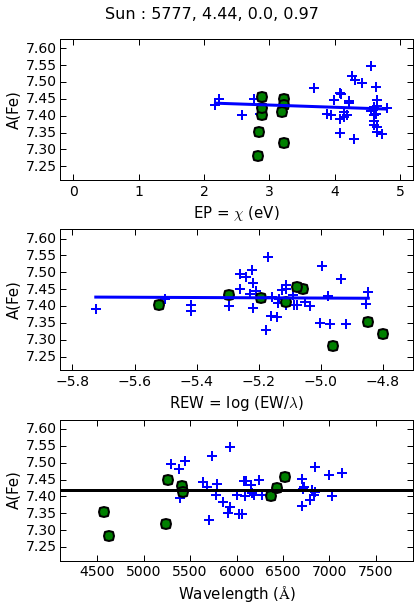

In [11]:
q2.specpars.iron_stats(sun, plot='sun')

Not only did we make a nice figure (look in the Demo folder for the "sun.png" file; the name of this file is set by the plot argument above), but the sun object now has an "iron_stats" attribute with the results of this calculation, so we can use them for statistics. By the way, in the figure, blue crosses here are the FeI lines and green circles the FeII lines. The solid blue lines are linear fits to the data and the black line in the bottom panel is a horizontal line at the average value of the iron abundance.

Let's have a look at the results from the calculation above:

In [12]:
print "A(Fe I)  = {0:5.3f} +/- {1:5.3f}".\
      format(sun.iron_stats['afe1'], sun.iron_stats['err_afe1'])
print "A(Fe II) = {0:5.3f} +/- {1:5.3f}".\
      format(sun.iron_stats['afe2'], sun.iron_stats['err_afe2'])
print "A(FeI) vs. EP slope  = {0:.6f}".format(sun.iron_stats['slope_ep'])
print "A(FeI) vs. REW slope = {0:.6f}".format(sun.iron_stats['slope_rew'])

A(Fe I)  = 7.424 +/- 0.049
A(Fe II) = 7.392 +/- 0.061
A(FeI) vs. EP slope  = -0.006651
A(FeI) vs. REW slope = -0.003948


There is some flexibility to modify the plots generated by q<sup>2</sup> with a PlotPars object, which can be passed on to q2.specpars. For example, we can set the y-axis to be +/-0.25 from the mean iron abundance derived as shown below. Also, note that now we are doing a calculation for Arcturus (check the Demo folder again after this calculation for the output figure: "arcturus.png").

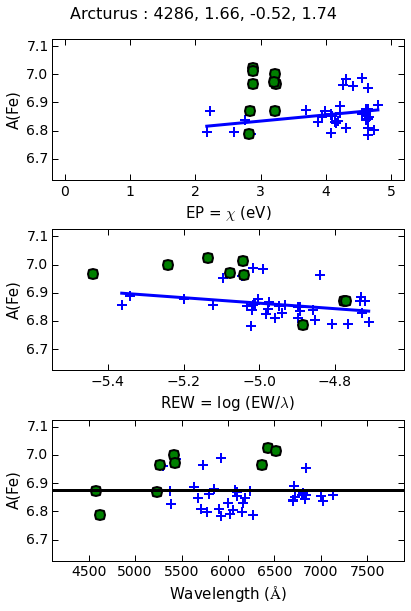

In [13]:
pp = q2.specpars.PlotPars()
pp.afe = [-1000, 0.25]
q2.specpars.iron_stats(arcturus, plot='arcturus', PlotPars=pp)

So far we have used q<sup>2</sup> to calculate absolute abundances of the Sun and Arcturus, but what about a differential analysis? We can run q2.specpars.iron_stats for Arcturus using the Sun as the reference star and all we have to do is pass the object sun as Ref(erence):

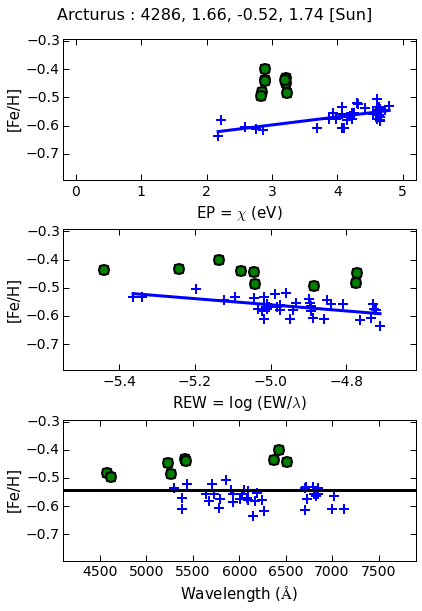

In [14]:
q2.specpars.iron_stats(arcturus, Ref=sun, plot='arcturus_sun', PlotPars=pp)

This created a figure "arcturus_sun.png" in the Demo folder. The y-axis label is now [Fe/H], not A(Fe). Note that we didn't have to deal with the MOOG outputs, match line lists, create tables and do the math separately. All that was handled by q<sup>2</sup>.

This concludes the Introduction. So far we have calculated iron abundances using input parameters as given in our csv files. As shown in the figure we just made, the iron abundances of Arcturus show trends with excitation potential and line-strength. Also, the mean FeI and FeII abundances are a bit different. This could be indicating that the input parameters used are not correct (within our 1D-LTE model assumptions). Let's move on to Part 2 of this Tutorial and use q<sup>2</sup> to derive "better" fundamental stellar parameters of stars.